In [1]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from nltk.corpus import stopwords
import scipy
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm import tqdm
%matplotlib inline
import pickle
pd.options.display.max_columns = 200

In [2]:
SEED=411 
kf = KFold(5, shuffle=True, random_state=SEED)

In [3]:
target = 'deal_probability'
y_train = pd.read_csv('data/train.csv', usecols=['activation_date', 'deal_probability'], parse_dates=['activation_date']) \
            .sort_values('activation_date') \
            .reset_index(drop=True).deal_probability.values

In [4]:
y_vc = pd.Series(y_train).value_counts()
y_vc

0.00000    974618
0.80323     46683
0.76786     26489
0.86521     23275
0.73760     13928
1.00000     10076
0.82668      8501
0.78503      8446
0.20000      8085
0.40000      6302
0.12579      5248
0.25000      5001
0.27307      4538
0.50000      4259
0.60000      4218
0.33973      3364
0.38925      2859
0.70397      2857
0.80000      2654
0.12869      2634
0.75000      2558
0.12459      2538
0.39355      2533
0.08952      2423
0.86520      2423
0.12895      2171
0.12152      2034
0.15813      1865
0.05499      1845
0.05193      1738
            ...  
0.43729         1
0.72646         1
0.24472         1
0.42538         1
0.16198         1
0.56317         1
0.38345         1
0.33643         1
0.47211         1
0.71893         1
0.04974         1
0.03908         1
0.47618         1
0.27302         1
0.26967         1
0.47642         1
0.20224         1
0.69280         1
0.10651         1
0.76056         1
0.63028         1
0.37771         1
0.76697         1
0.46737         1
0.23151   

In [5]:
y_vc[y_vc>1000].sort_index()

0.00000    974618
0.03127      1274
0.03187      1574
0.03227      1420
0.05193      1738
0.05219      1219
0.05268      1338
0.05499      1845
0.06514      1090
0.07498      1530
0.07654      1042
0.08952      2423
0.09963      1092
0.11840      1100
0.12152      2034
0.12396      1152
0.12459      2538
0.12579      5248
0.12734      1458
0.12869      2634
0.12895      2171
0.13301      1334
0.14983      1521
0.15813      1865
0.15828      1123
0.16667      1657
0.16934      1638
0.20000      8085
0.20728      1467
0.20952      1293
0.25000      5001
0.27307      4538
0.31492      1174
0.33973      3364
0.38925      2859
0.39355      2533
0.39373      1297
0.40000      6302
0.47553      1259
0.50000      4259
0.60000      4218
0.70397      2857
0.73760     13928
0.74043      1320
0.74424      1149
0.75000      2558
0.76786     26489
0.76824      1173
0.78503      8446
0.78912      1187
0.80000      2654
0.80323     46683
0.82668      8501
0.86520      2423
0.86521     23275
1.00000   

In [6]:
bins = np.arange(0, 1.125, 0.125)
bins

array([ 0.   ,  0.125,  0.25 ,  0.375,  0.5  ,  0.625,  0.75 ,  0.875,  1.   ])

In [7]:
#y_train = pd.Series(y_train).map(lambda x: np.argmin(np.absolute(bins-x)))
y_train = np.where(y_train == 0, 
                   y_train,
                   np.where(y_train == 1, 2, 1))

In [8]:
pd.Series(y_train).value_counts()

0.0    974618
1.0    518730
2.0     10076
dtype: int64

In [9]:
plants = pd.read_csv('all_features_plantsgo.csv.zip')

In [10]:
print(plants.shape)
plants

(2011862, 153)


,price,image_top_1,item_seq_number,activation_weekday,avg_days_up_user,avg_times_up_user,n_user_items,"cat_features_user_id_category_name_Одежда, обувь, аксессуары",cat_features_user_id_category_name_Детская одежда и обувь,cat_features_user_id_category_name_Товары для детей и игрушки,cat_features_user_id_category_name_Предложение услуг,cat_features_user_id_category_name_Квартиры,cat_features_user_id_category_name_Ремонт и строительство,cat_features_user_id_category_name_Мебель и интерьер,cat_features_user_id_category_name_Телефоны,cat_features_user_id_category_name_Коллекционирование,cat_features_user_id_category_name_Автомобили,"cat_features_user_id_category_name_Дома, дачи, коттеджи",cat_features_user_id_category_name_Товары для компьютера,cat_features_user_id_category_name_Аудио и видео,cat_features_user_id_category_name_Красота и здоровье,cat_features_user_id_category_name_Спорт и отдых,cat_features_user_id_category_name_Бытовая техника,cat_features_user_id_category_name_Часы и украшения,cat_features_user_id_category_name_Книги и журналы,cat_features_user_id_category_name_Оборудование для бизнеса,cat_features_user_id_category_name_Земельные участки,cat_features_user_id_category_name_Посуда и товары для кухни,cat_features_user_id_category_name_Товары для животных,cat_features_user_id_category_name_Фототехника,"cat_features_user_id_category_name_Игры, приставки и программы",cat_features_user_id_category_name_Грузовики и спецтехника,cat_features_user_id_category_name_Коммерческая недвижимость,cat_features_user_id_category_name_Оргтехника и расходники,cat_features_user_id_category_name_Растения,cat_features_user_id_category_name_Гаражи и машиноместа,cat_features_user_id_category_name_Планшеты и электронные книги,cat_features_user_id_category_name_Велосипеды,cat_features_user_id_category_name_Комнаты,cat_features_user_id_category_name_Музыкальные инструменты,cat_features_user_id_category_name_Собаки,cat_features_user_id_category_name_Ноутбуки,cat_features_user_id_category_name_Другие животные,cat_features_user_id_category_name_Охота и рыбалка,cat_features_user_id_category_name_Продукты питания,cat_features_user_id_category_name_Настольные компьютеры,cat_features_user_id_category_name_Кошки,cat_features_user_id_category_name_Аквариум,cat_features_user_id_category_name_Мотоциклы и мототехника,cat_features_user_id_category_name_Птицы,cat_features_user_id_category_name_Водный транспорт,cat_features_user_id_category_name_Готовый бизнес,cat_features_user_id_category_name_Билеты и путешествия,cat_features_user_id_category_name_Недвижимость за рубежом,price_pred,price_pred_onlydescription,price_pred_all,ridge_preds,ridge_preds_title,ridge_preds_description,ga,region,city,parent_category_name,category_name,user_type,param_1,param_2,param_3,title_tfidf_svd_1,title_tfidf_svd_2,title_tfidf_svd_3,title_tfidf_svd_4,title_tfidf_svd_5,description_tfidf_svd_1,description_tfidf_svd_2,description_tfidf_svd_3,description_tfidf_svd_4,description_tfidf_svd_5,region_mean_price,region_mean_image_top_1,region_mean_item_seq_number,region_mean_price_pred,region_mean_price_pred_all,region_mean_ridge_preds,city_mean_price,city_mean_image_top_1,city_mean_item_seq_number,city_mean_price_pred,city_mean_price_pred_all,city_mean_ridge_preds,parent_category_name_mean_price,parent_category_name_mean_image_top_1,parent_category_name_mean_item_seq_number,parent_category_name_mean_price_pred,parent_category_name_mean_price_pred_all,parent_category_name_mean_ridge_preds,category_name_mean_price,category_name_mean_image_top_1,category_name_mean_item_seq_number,category_name_mean_price_pred,category_name_mean_price_pred_all,category_name_mean_ridge_preds,user_type_mean_price,user_type_mean_image_top_1,user_type_mean_item_seq_number,user_type_mean_price_pred,user_type_mean_price_pred_all,user_type_mean_ridge_preds,param_1_mean_price,param_1_mean_image_top_1,param_1_mean_item_seq_number,param_1_mean_price_pred,param_1_mean_price_pred_all,param_1_mean_ridge_preds,param_2_

In [11]:
#plants.drop([col for col in plants.columns if 'ridge_preds' in col], axis=1, inplace=True)        
plants.columns.tolist()

['price',
 'image_top_1',
 'item_seq_number',
 'activation_weekday',
 'avg_days_up_user',
 'avg_times_up_user',
 'n_user_items',
 'cat_features_user_id_category_name_Одежда, обувь, аксессуары',
 'cat_features_user_id_category_name_Детская одежда и обувь',
 'cat_features_user_id_category_name_Товары для детей и игрушки',
 'cat_features_user_id_category_name_Предложение услуг',
 'cat_features_user_id_category_name_Квартиры',
 'cat_features_user_id_category_name_Ремонт и строительство',
 'cat_features_user_id_category_name_Мебель и интерьер',
 'cat_features_user_id_category_name_Телефоны',
 'cat_features_user_id_category_name_Коллекционирование',
 'cat_features_user_id_category_name_Автомобили',
 'cat_features_user_id_category_name_Дома, дачи, коттеджи',
 'cat_features_user_id_category_name_Товары для компьютера',
 'cat_features_user_id_category_name_Аудио и видео',
 'cat_features_user_id_category_name_Красота и здоровье',
 'cat_features_user_id_category_name_Спорт и отдых',
 'cat_feature

In [12]:
train_plants = plants.loc[:len(y_train)-1,:]
test_plants = plants.loc[len(y_train):,:].reset_index(drop=True)
del plants; gc.collect()

64

In [13]:
train_plants.shape, test_plants.shape

((1503424, 153), (508438, 153))

In [14]:
'''
origin = pd.read_csv('data/train.csv', usecols=['activation_date', 'item_id'], parse_dates=['activation_date'])
train_item_id = origin.sort_values('activation_date').reset_index(drop=True).item_id.values
del origin; gc.collect()

origin = pd.read_csv('data/test.csv', usecols=['item_id'])
test_item_id = origin.item_id.values
del origin; gc.collect()

train = pickle.load(open('train_selected_features', 'rb'))
test = pickle.load(open('test_selected_features', 'rb'))
train['item_id'] = train_item_id
test['item_id'] = test_item_id

train = train.merge(train_plants, on='item_id', how='left')
test = test.merge(test_plants, on='item_id', how='left')

train.drop('item_id', axis=1, inplace=True)
test.drop('item_id', axis=1, inplace=True)

del train_plants, test_plants; gc.collect()
'''

train = train_plants
test = test_plants

origin = pd.read_csv('data/train.csv', usecols=['activation_date', 'item_id'], parse_dates=['activation_date'])
train['activation_date'] = origin['activation_date']
train = train.sort_values('activation_date').reset_index(drop=True).drop('activation_date', axis=1)
train.drop('item_id', axis=1, inplace=True)
test.drop('item_id', axis=1, inplace=True)

C:\Users\khyeh\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [15]:
train = pd.concat([train, pickle.load(open('train_selected_features', 'rb'))], axis=1)
test = pd.concat([test, pickle.load(open('test_selected_features', 'rb'))], axis=1)

In [16]:
print(train.shape)
train

(1503424, 213)


,price,image_top_1,item_seq_number,activation_weekday,avg_days_up_user,avg_times_up_user,n_user_items,"cat_features_user_id_category_name_Одежда, обувь, аксессуары",cat_features_user_id_category_name_Детская одежда и обувь,cat_features_user_id_category_name_Товары для детей и игрушки,cat_features_user_id_category_name_Предложение услуг,cat_features_user_id_category_name_Квартиры,cat_features_user_id_category_name_Ремонт и строительство,cat_features_user_id_category_name_Мебель и интерьер,cat_features_user_id_category_name_Телефоны,cat_features_user_id_category_name_Коллекционирование,cat_features_user_id_category_name_Автомобили,"cat_features_user_id_category_name_Дома, дачи, коттеджи",cat_features_user_id_category_name_Товары для компьютера,cat_features_user_id_category_name_Аудио и видео,cat_features_user_id_category_name_Красота и здоровье,cat_features_user_id_category_name_Спорт и отдых,cat_features_user_id_category_name_Бытовая техника,cat_features_user_id_category_name_Часы и украшения,cat_features_user_id_category_name_Книги и журналы,cat_features_user_id_category_name_Оборудование для бизнеса,cat_features_user_id_category_name_Земельные участки,cat_features_user_id_category_name_Посуда и товары для кухни,cat_features_user_id_category_name_Товары для животных,cat_features_user_id_category_name_Фототехника,"cat_features_user_id_category_name_Игры, приставки и программы",cat_features_user_id_category_name_Грузовики и спецтехника,cat_features_user_id_category_name_Коммерческая недвижимость,cat_features_user_id_category_name_Оргтехника и расходники,cat_features_user_id_category_name_Растения,cat_features_user_id_category_name_Гаражи и машиноместа,cat_features_user_id_category_name_Планшеты и электронные книги,cat_features_user_id_category_name_Велосипеды,cat_features_user_id_category_name_Комнаты,cat_features_user_id_category_name_Музыкальные инструменты,cat_features_user_id_category_name_Собаки,cat_features_user_id_category_name_Ноутбуки,cat_features_user_id_category_name_Другие животные,cat_features_user_id_category_name_Охота и рыбалка,cat_features_user_id_category_name_Продукты питания,cat_features_user_id_category_name_Настольные компьютеры,cat_features_user_id_category_name_Кошки,cat_features_user_id_category_name_Аквариум,cat_features_user_id_category_name_Мотоциклы и мототехника,cat_features_user_id_category_name_Птицы,cat_features_user_id_category_name_Водный транспорт,cat_features_user_id_category_name_Готовый бизнес,cat_features_user_id_category_name_Билеты и путешествия,cat_features_user_id_category_name_Недвижимость за рубежом,price_pred,price_pred_onlydescription,price_pred_all,ridge_preds,ridge_preds_title,ridge_preds_description,ga,region,city,parent_category_name,category_name,user_type,param_1,param_2,param_3,title_tfidf_svd_1,title_tfidf_svd_2,title_tfidf_svd_3,title_tfidf_svd_4,title_tfidf_svd_5,description_tfidf_svd_1,description_tfidf_svd_2,description_tfidf_svd_3,description_tfidf_svd_4,description_tfidf_svd_5,region_mean_price,region_mean_image_top_1,region_mean_item_seq_number,region_mean_price_pred,region_mean_price_pred_all,region_mean_ridge_preds,city_mean_price,city_mean_image_top_1,city_mean_item_seq_number,city_mean_price_pred,city_mean_price_pred_all,city_mean_ridge_preds,parent_category_name_mean_price,parent_category_name_mean_image_top_1,parent_category_name_mean_item_seq_number,parent_category_name_mean_price_pred,parent_category_name_mean_price_pred_all,parent_category_name_mean_ridge_preds,category_name_mean_price,category_name_mean_image_top_1,category_name_mean_item_seq_number,...,param_1_mean_price_pred_all,param_1_mean_ridge_preds,param_2_mean_price,param_2_mean_image_top_1,param_2_mean_item_seq_number,param_2_mean_price_pred,param_2_mean_price_pred_all,param_2_mean_ridge_preds,param_3_mean_price,param_3_mean_image_top_1,param_3_mean_item_seq_number,param_3_mean_price_pred,param_3_mean_price_pred_all,param_3_mean_ridge_preds,user_id_nunique_parent_category_name,user_id_nunique_categ

In [17]:
from GridSearcher import data_loader, model_loader, fit_params, get_oof_predictions
ml = model_loader('lgb')
n_class = 3

In [18]:
rounds = 20000
early_stop_rounds = 200

params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'min_child_weight': 1.5,
    'num_leaves': 2 ** 5,
    'lambda_l2': 10,
    'subsample': 0.7,
    'colsample_bytree': 0.5,
    'colsample_bylevel': 0.5,
    'learning_rate': 0.1,
    'seed': 2018,
    'nthread': 4,
    'silent': True,
    'num_class': n_class
}

ret = np.zeros((train.shape[0],n_class))
ret_test = np.zeros((test.shape[0],n_class))
ret_models = []

for train_ix, val_ix in kf.split(train):
    dtrain = lgb.Dataset(train.loc[train_ix,:], label=y_train[train_ix]) 
                         #feature_name=list(feature_names),
                         #categorical_feature=categorical)
    dvalid = lgb.Dataset(train.loc[val_ix,:], label=y_train[val_ix]) 
                         #feature_name=list(feature_names),) 
                         #categorical_feature=categorical)
    
    model = lgb.train(params, dtrain, 
                      valid_sets=[dtrain, dvalid], 
                      valid_names=['train', 'valid'],
                      num_boost_round=rounds, 
                      early_stopping_rounds=early_stop_rounds, 
                      verbose_eval=100)
    #print(model.predict(train.loc[val_ix,:]))
    ret[val_ix,:] = model.predict(train.loc[val_ix,:])
    ret_test += model.predict(test)
    ret_models.append(model)
    
    del dtrain, dvalid
    
ret_test = ret_test / 5.

Training until validation scores don't improve for 200 rounds.
[100]	train's multi_logloss: 0.481588	valid's multi_logloss: 0.484441
[200]	train's multi_logloss: 0.473107	valid's multi_logloss: 0.47902
[300]	train's multi_logloss: 0.468691	valid's multi_logloss: 0.477587
[400]	train's multi_logloss: 0.464912	valid's multi_logloss: 0.476678
[500]	train's multi_logloss: 0.461393	valid's multi_logloss: 0.475988
[600]	train's multi_logloss: 0.458074	valid's multi_logloss: 0.475436
[700]	train's multi_logloss: 0.454946	valid's multi_logloss: 0.474988
[800]	train's multi_logloss: 0.45195	valid's multi_logloss: 0.474608
[900]	train's multi_logloss: 0.449096	valid's multi_logloss: 0.474322
[1000]	train's multi_logloss: 0.446353	valid's multi_logloss: 0.474098
[1100]	train's multi_logloss: 0.443696	valid's multi_logloss: 0.473903
[1200]	train's multi_logloss: 0.441057	valid's multi_logloss: 0.473723
[1300]	train's multi_logloss: 0.43848	valid's multi_logloss: 0.473524
[1400]	train's multi_loglo

[800]	train's multi_logloss: 0.451901	valid's multi_logloss: 0.475466
[900]	train's multi_logloss: 0.449109	valid's multi_logloss: 0.475221
[1000]	train's multi_logloss: 0.446341	valid's multi_logloss: 0.474985
[1100]	train's multi_logloss: 0.443631	valid's multi_logloss: 0.47476
[1200]	train's multi_logloss: 0.441044	valid's multi_logloss: 0.474567
[1300]	train's multi_logloss: 0.438456	valid's multi_logloss: 0.474391
[1400]	train's multi_logloss: 0.435947	valid's multi_logloss: 0.474282
[1500]	train's multi_logloss: 0.433466	valid's multi_logloss: 0.474128
[1600]	train's multi_logloss: 0.431116	valid's multi_logloss: 0.474063
[1700]	train's multi_logloss: 0.42871	valid's multi_logloss: 0.473994
[1800]	train's multi_logloss: 0.426392	valid's multi_logloss: 0.473895
[1900]	train's multi_logloss: 0.424123	valid's multi_logloss: 0.473849
[2000]	train's multi_logloss: 0.421911	valid's multi_logloss: 0.473774
[2100]	train's multi_logloss: 0.419745	valid's multi_logloss: 0.473754
[2200]	tra

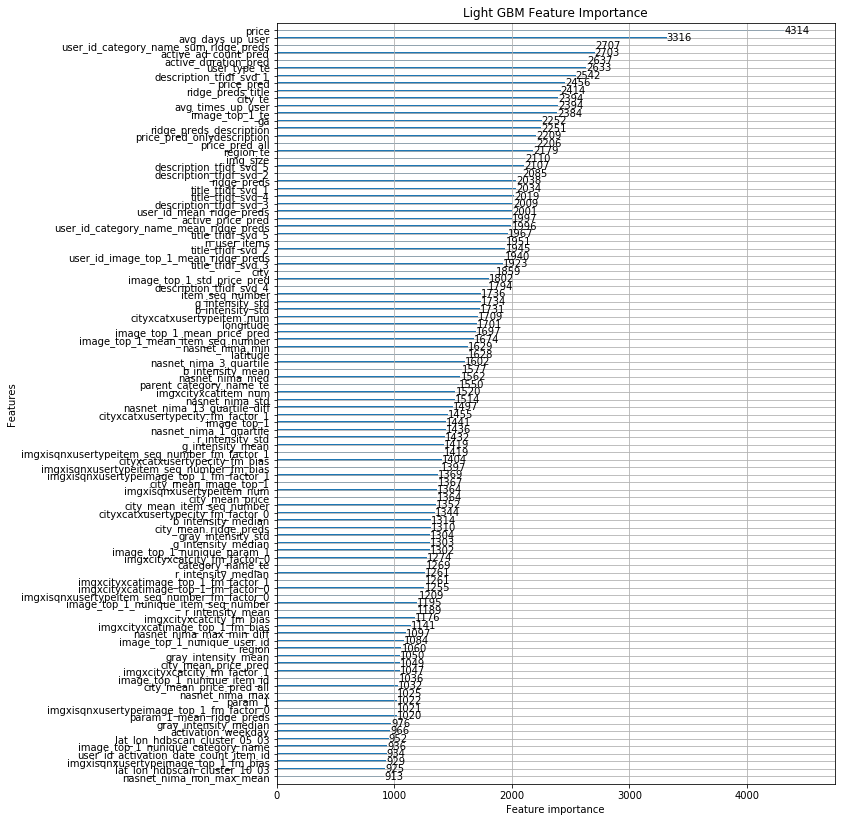

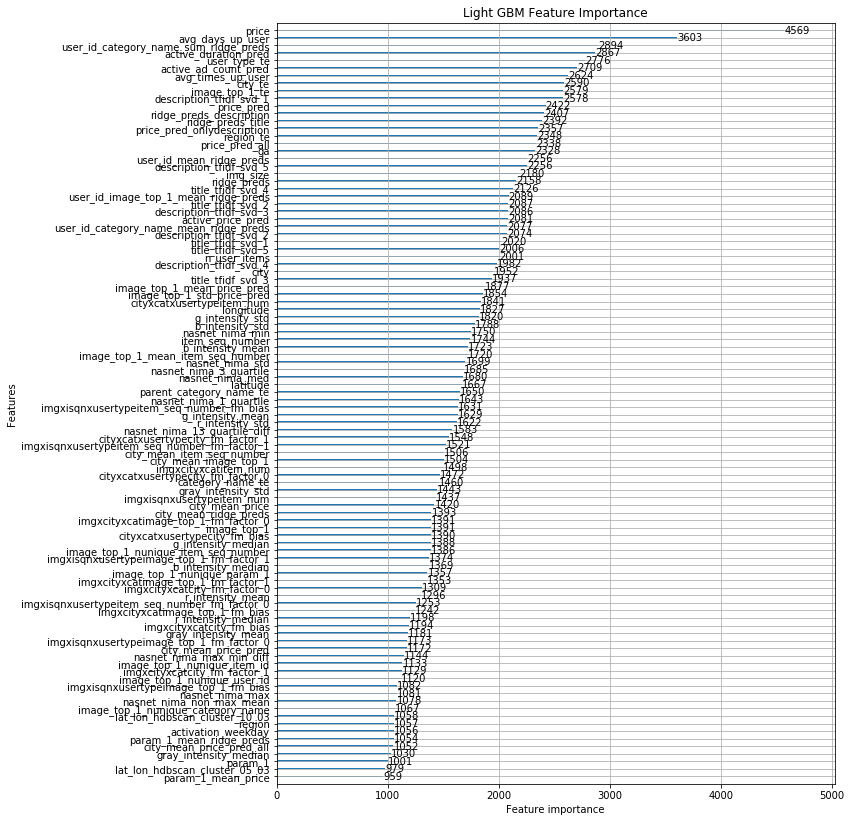

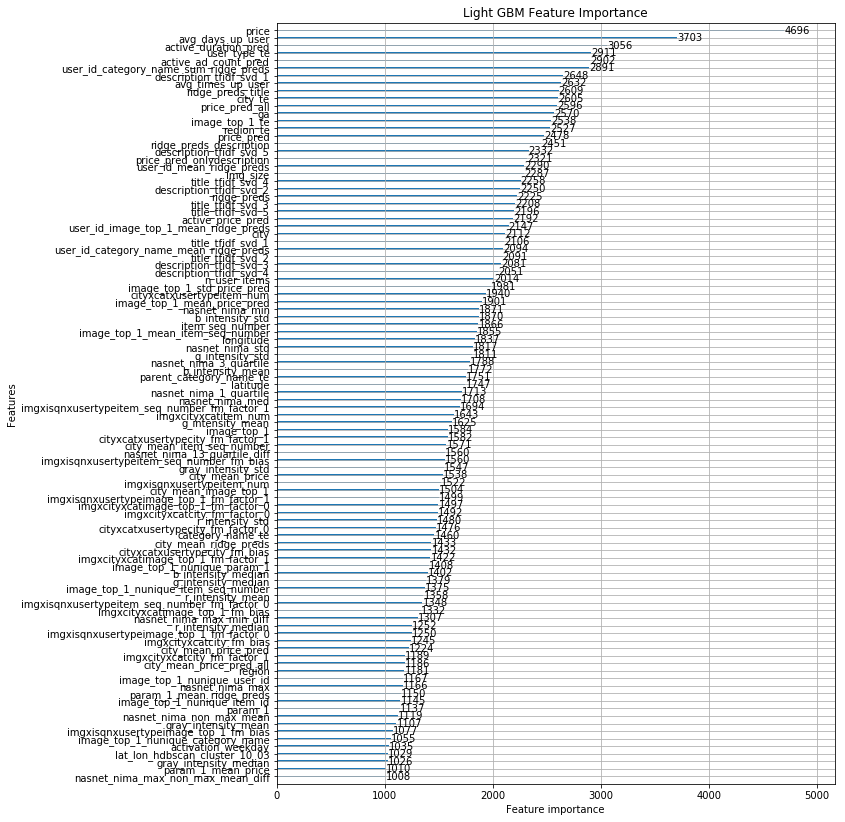

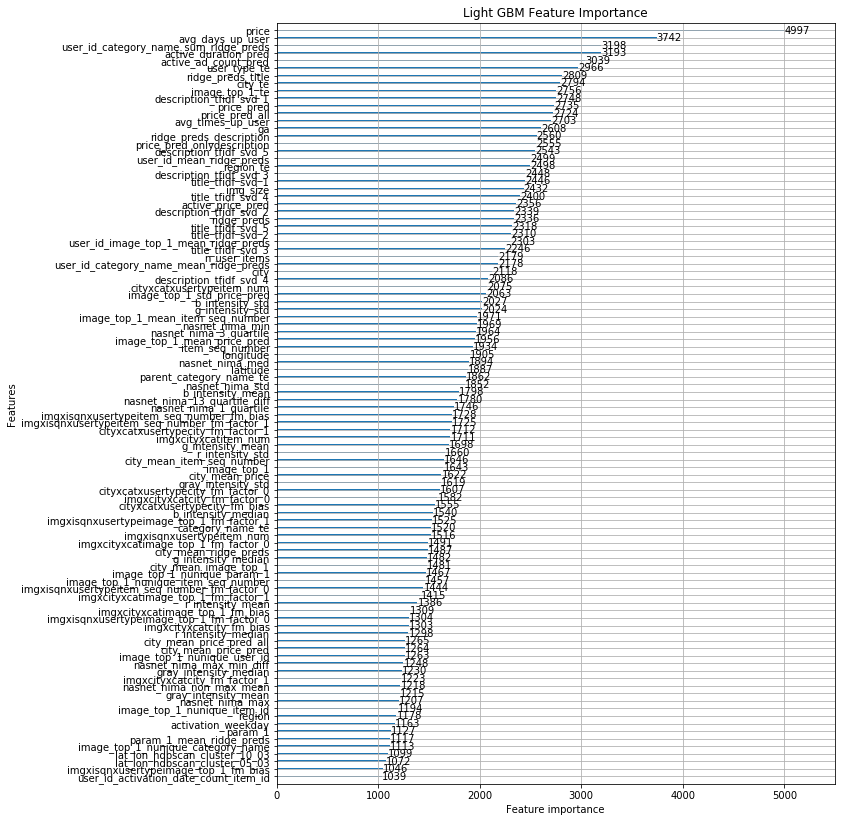

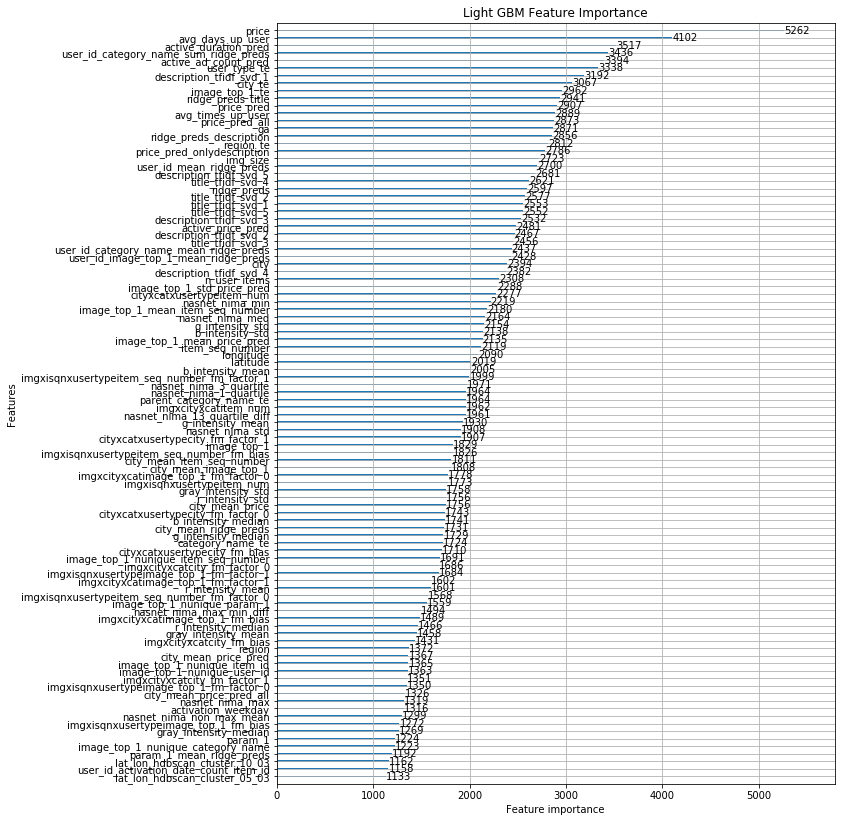

In [19]:
for model in ret_models:
    fig, ax = plt.subplots(figsize=(10, 14))
    lgb.plot_importance(model, max_num_features=100, ax=ax)
    plt.title("Light GBM Feature Importance")
    plt.show()

In [20]:
prefix = 'multiclass3_lgb'

In [21]:
oof_val = pd.DataFrame(data=ret, columns=[prefix+'_pred'+str(i) for i in range(n_class)])
oof_test = pd.DataFrame(data=ret_test, columns=[prefix+'_pred'+str(i) for i in range(n_class)])

In [22]:
oof_val.loc[:,prefix+'rank'] = np.argmax(oof_val.values, axis=1).flatten()
oof_test.loc[:,prefix+'rank'] = np.argmax(oof_test.values, axis=1).flatten()

In [23]:
oof_val.to_csv(prefix+'_oof_val_pred.csv', index=False)
oof_test.to_csv(prefix+'_oof_test_pred.csv', index=False)

In [24]:
oof_val

,multiclass3_lgb_pred0,multiclass3_lgb_pred1,multiclass3_lgb_pred2,multiclass3_lgbrank
0,0.825805,0.174195,2.028973e-07,0
1,0.800754,0.199246,1.017860e-07,0
2,0.805135,0.194865,6.909815e-08,0
3,0.613658,0.386341,1.043365e-06,0
4,0.692647,0.307353,5.348553e-08,0
5,0.851422,0.148577,2.843950e-07,0
6,0.885499,0.114501,4.502777e-07,0
7,0.333138,0.666859,3.363175e-06,1
8,0.208981,0.791016,2.471067e-06,1
9,0.592093,0.407905,1.770546e-06,0


In [26]:
oof_val['multiclass3_lgbrank'].value_counts()

0    1031333
1     467757
2       4334
Name: multiclass3_lgbrank, dtype: int64